In [3]:
import pandas as pd
from mordred import Calculator, descriptors
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors
from rdkit.Chem.EState import Fingerprinter
from rdkit.Chem import PandasTools
from sklearn.preprocessing import StandardScaler 

# 读取数据表
data = pd.read_csv('beta.csv')  # 替换为您的数据表路径和名称
pre_data = pd.read_csv('beta-20241016.csv') 
# 分割训练集和验证集
train_data = data[data['group'] == 'training']
test_data = data[data['group'] == 'test']

PandasTools.AddMoleculeColumnToFrame(train_data,'smiles','Molecule')
PandasTools.AddMoleculeColumnToFrame(test_data,'smiles','Molecule')
PandasTools.AddMoleculeColumnToFrame(pre_data,'smiles','Molecule')

calc = Calculator(descriptors, ignore_3D=True)
X_train = pd.DataFrame(calc.pandas(train_data['Molecule']))
X_test = pd.DataFrame(calc.pandas(test_data['Molecule']))
X_pre = pd.DataFrame(calc.pandas(pre_data['Molecule']))

data1=pd.concat([X_train,X_test])
data1=pd.concat([data1,X_pre])
data1=data1._get_numeric_data()
y_train=train_data[train_data.columns[4]].values
y_test=test_data[test_data.columns[4]].values
y_pre=pre_data[pre_data.columns[4]].values
X_train=pd.concat([train_data.iloc[:,5:9],data1.iloc[:51,:]],axis=1)
X_test=pd.concat([test_data.iloc[:,5:9],data1.iloc[51:63,:]],axis=1)
X_pre=pd.concat([pre_data.iloc[:,5:9],data1.iloc[63:,:]],axis=1)

E:\Anaconda\lib\site-packages\rdkit\Chem\PandasTools.py:416: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)
100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.45it/s]


In [2]:
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from hyperopt import hp, fmin, tpe, Trials


# 定义超参数搜索空间
space = {
    'n_estimators': hp.choice('n_estimators',(10,50,100)),
    'max_depth': hp.choice('max_depth', (1,2,3,4,5,6,7,8,9, 10)),
    'learning_rate': hp.choice('learning_rate', (0.0001,0.001,0.01,0.1,1)),
    'subsample': hp.choice('subsample', (0.5,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95, 1)),
    'colsample_bytree': hp.choice('colsample_bytree', (0.5,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95, 1)),
    'gamma': hp.choice('gamma', (0,1,2,3,4,5,6,7,8,9,10))
}

# 定义目标函数
def objective(params):
    # 构建XGBoost模型
    model = xgb.XGBRegressor(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        learning_rate=params['learning_rate'],
        gamma=params['gamma']
    )

    # 进行交叉验证
    cv_result = xgb.cv(
        model.get_xgb_params(),
        xgb.DMatrix(X_train, label=y_train),
        nfold=10,
        metrics='rmse',
        seed=666
    )

    # 返回交叉验证的均方根误差（RMSE）作为目标值
    return cv_result['test-rmse-mean'].iloc[-1]

# 运行超参数优化
trials = Trials()
best = fmin(
    objective,
    space=space,
    algo=tpe.suggest,
    max_evals=10,
    trials=trials
)

# 输出最佳超参数组合
print("Best Hyperparameters:")
print(best)

100%|████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it, best loss: 0.2397338]
Best Hyperparameters:
{'colsample_bytree': 7, 'gamma': 1, 'learning_rate': 1, 'max_depth': 8, 'n_estimators': 0, 'subsample': 7}


Training Set - R2: 0.9999, MAE: 0.0018, RMSE: 0.0027
Validation Set - R2: 0.8644, MAE: 0.0407, RMSE: 0.0525


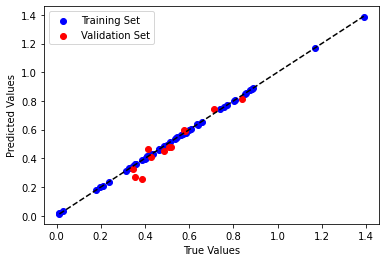

In [4]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
best_hyperparameters = {}

model = xgb.XGBRegressor(**best_hyperparameters)


# 训练模型
model.fit(X_train, y_train)

# 在训练集和验证集上进行预测
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# 计算 R2 分数
r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_test, y_test_pred)

# 计算 MAE 和 MSE
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_val = mean_absolute_error(y_test, y_test_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_val = np.sqrt(mean_squared_error(y_test, y_test_pred))

# 打印结果
print("Training Set - R2: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}".format(r2_train, mae_train, rmse_train))
print("Validation Set - R2: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}".format(r2_val, mae_val, rmse_val))

# 绘制散点图
plt.scatter(y_train, y_train_pred, color='blue', label='Training Set')
plt.scatter(y_test, y_test_pred, color='red', label='Validation Set')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='black', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [5]:
y_pre_pred = model.predict(X_pre)
pd.DataFrame(y_pre, y_pre_pred).to_csv("beta-pre-XG.csv")

In [10]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model,X_train, y_train,cv=5) #cv：默认是3折交叉验证，可以修改cv=5，变成5折交叉验证。
print("Cross validation scores:{}".format(scores))
print("Mean cross validation score:{:2f}".format(scores.mean()))


Cross validation scores:[ -7.86785647 -16.9623038  -70.11479153 -11.21379977  -2.89297386]
Mean cross validation score:-21.810345


In [5]:
pd.DataFrame(y_train, y_train_pred).to_csv("beta-train-Xgboost.csv")
pd.DataFrame(y_test, y_test_pred).to_csv("beta-test-Xgboost.csv")